In [23]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, matthews_corrcoef
from imblearn.over_sampling import SMOTENC

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline
RSEED=42

In [2]:
df = pd.read_csv('../data/training_new.csv')
df.head()

,ProviderId,ProductCategory,ChannelId,PricingStrategy,weekday,difference,IsDebit,Value,time_of_day,FraudResult
0,ProviderId_6,airtime,ChannelId_3,2,3,0.0,1,1000,8329,0
1,ProviderId_4,financial_services,ChannelId_2,2,3,0.0,0,20,8348,0
2,ProviderId_6,airtime,ChannelId_3,2,3,0.0,1,500,9861,0
3,ProviderId_1,utility_bill,ChannelId_3,2,3,1.0,1,21800,12775,0
4,ProviderId_4,financial_services,ChannelId_2,2,3,0.0,0,644,12861,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ProviderId       95662 non-null  object 
 1   ProductCategory  95662 non-null  object 
 2   ChannelId        95662 non-null  object 
 3   PricingStrategy  95662 non-null  int64  
 4   weekday          95662 non-null  int64  
 5   difference       95662 non-null  float64
 6   IsDebit          95662 non-null  int64  
 7   Value            95662 non-null  int64  
 8   time_of_day      95662 non-null  int64  
 9   FraudResult      95662 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 7.3+ MB


In [4]:
df[['PricingStrategy', 'weekday', 'difference', 'IsDebit']] = df[['PricingStrategy', 'weekday', 'difference', 'IsDebit']].astype('object')

In [5]:
# Define predictors
X = df.drop('FraudResult', axis=1)

# Define target variable
y = df['FraudResult']

In [6]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED, stratify=y, test_size = .25)

## Balancing the Training Dataset

In [7]:
# change to np.array for smote
features = ["ProviderId", "ProductCategory", "ChannelId", "PricingStrategy", 
    "weekday", "difference", "IsDebit", "Value", "time_of_day"]

X_train = np.array(
    X_train[features]
    )

In [8]:
# initiate smotenc
sm = SMOTENC(categorical_features=[0, 1, 2, 3, 4, 5, 6], random_state = RSEED)
# run smotenc
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [9]:
# transform back into a data frame
X_train_sm = pd.DataFrame(X_train_sm)

In [10]:
X_train_sm.columns = ["ProviderId", "ProductCategory", "ChannelId", "PricingStrategy", 
    "weekday", "difference", "IsDebit", "Value", "time_of_day"]
X_train_sm = X_train_sm.astype({"Value": "int32", "time_of_day": "int32"})

In [11]:
X_train_sm

,ProviderId,ProductCategory,ChannelId,PricingStrategy,weekday,difference,IsDebit,Value,time_of_day
0,ProviderId_4,financial_services,ChannelId_2,2,4,0.0,0,200,28699
1,ProviderId_4,financial_services,ChannelId_2,2,0,0.0,0,40,41786
2,ProviderId_4,financial_services,ChannelId_2,2,6,0.0,0,50,61735
3,ProviderId_6,airtime,ChannelId_3,2,0,0.0,1,1000,65871
4,ProviderId_6,airtime,ChannelId_3,2,4,0.0,1,2000,49474
...,...,...,...,...,...,...,...,...,...
143197,ProviderId_1,financial_services,ChannelId_3,2,1,0.0,1,7812988,23404
143198,ProviderId_1,financial_services,ChannelId_3,4,1,0.0,1,500000,50042
143199,ProviderId_3,financial_services,ChannelId_3,2,5,0.0,1,500000,41148
143200,ProviderId_5,financial_services,ChannelId_3,2,2,0.0,1,800000,67202


In [12]:
# distinguish between numerical and categorical features
cat_features = [
   "ProviderId", "ProductCategory", "ChannelId", "PricingStrategy", 
    "weekday", "difference", "IsDebit"
    ]
num_features = ["Value", "time_of_day"]

In [13]:
# Initiate scaler
scaler = StandardScaler()

# run scaler
scaler = scaler.fit(X_train_sm[num_features])
X_train_sm[num_features] = scaler.transform(X_train_sm[num_features])

X_test[num_features] = scaler.transform(X_test[num_features])


In [14]:
# a function to create dummy variable
def create_dummies(X, cf):
    """function to get dummy variables 

    Args:
        X (pd.frame): test or train data
        cf (string): column names of categorical data in X

    """
    # all features should be categorical
    X[cf] = X[cf].astype("category")
    # get_dummies
    dummies = pd.get_dummies(X[cf], drop_first=True)
    X = X.drop(cf, axis=1)
    X[dummies.columns] = dummies
    
    return X, dummies.columns

In [15]:
# Create dummy variables for training and test set
X_train_sm_sc, cat_features_dummies = create_dummies(X_train_sm, cat_features)
X_test_sc, cat_features = create_dummies(X_test, cat_features)

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

# Initiate model
logreg = LogisticRegression(random_state = RSEED)
y_train_pred = logreg.fit(X_train_sm_sc, y_train_sm)
y_test_pred = logreg.predict(X_test_sc)

In [17]:
confusion_matrix(y_test, y_test_pred)

array([[23720,   148],
       [    2,    46]])

In [18]:
# Calculating the accuracy for the LogisticRegression Classifier 
print('Cross validation scores Logistic Regression:')
print('-------------------------')
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_pred)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_test_pred)))

Cross validation scores Logistic Regression:
-------------------------
F1-score: 0.38
MCC: 0.48


## Random forest classifier

In [20]:
# Train a Random Forest classifier

# Initiate model
rf = RandomForestClassifier(random_state=RSEED)
rf.fit(X_train_sm_sc, y_train_sm)
y_test_pred_rf = rf.predict(X_test_sc)

confusion_matrix(y_test, y_test_pred_rf)

array([[23845,    23],
       [    8,    40]])

In [21]:
# Get feature importances
rf_model = RandomForestClassifier(random_state=RSEED)
rf_model.fit(X_train_sm_sc, y_train_sm)
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

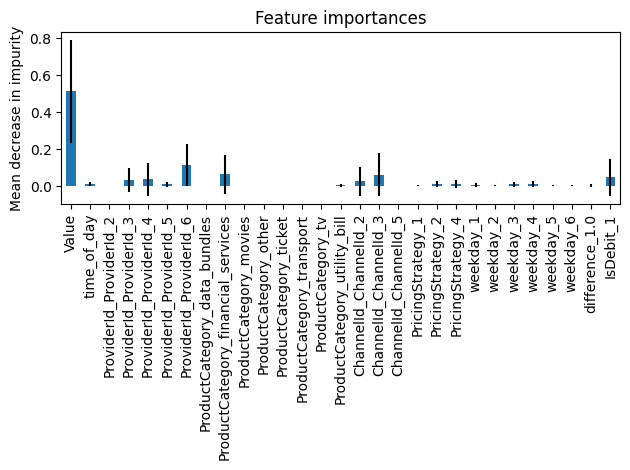

In [24]:
forest_importances = pd.Series(importances, index=X_train_sm_sc.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [26]:
# Calculating the accuracy for the RandomForest Classifier 
print('Cross validation scores Random Forest:')
print('-------------------------')
print("F1-score: {:.2f}".format(f1_score(y_test, y_test_pred_rf)))
print("MCC: {:.2f}".format(matthews_corrcoef(y_test, y_test_pred_rf)))

Cross validation scores Random Forest:
-------------------------
F1-score: 0.72
MCC: 0.73
